## **Automatic stratification of Tabular data using MDSS**

The goal of AutoStrat is to identify sub-populations who, as a group, have outcomes that significantly diverge from the overall population.

There are $\prod_{m=1}^{M}\left(2^{|X_{m}|}-1\right)$ unique subgroups from a dataset with $M$ features, with each feature having $|X_{m}|$ discretized values, where a subgroup is any $M$-dimension Cartesian set product, between subsets of feature-values from each feature --- excluding the empty set. MDSS mitigates this computational hurdle by approximately identifing the most statistically divergent subgroup in linear time (rather than exponential).




In this example, we have the 2014 and 2018 US Census-Income datasets, each of ~1.6 Million records where we observe a given individual represented by their census data as earning more than $50k/yr or not. These datasets are obtained from the [Folktables Python package](https://github.com/zykls/folktables) which provides access to datasets derived from the US Census. For the sake of these demo, we will sample only 100K records but feel free to use the whole dataset for your practice.

Since the outcome is binary, we can use a Bernoulli scoring function. Other scoring functions eg.`Poisson` may be appropriate for your dataset depending on the parametric assumptions of the outcome. In scenarios where we do not wish to make any parametric assumptions a scoring function like `BerkJones` may be more appropriate

Import the MDSS module and Bernoulli modules

In [1]:
from aif360.detectors.mdss_detector import bias_scan
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

We'll load the csv file obtained from the preprocessing notebook which downloads the data from Folktables. Note that the data containes categorical features and continous features have been binned. When applying autostrat, it is important that categorical features are not one-hot encoded as this may result in subsets that have individuals belonging to two different categories. The cardinality of each feature also influences run-time.

### Data

In [2]:
dff_2014 = pd.read_csv('folktables_adult_2014.csv')
dff_2018 = pd.read_csv('folktables_adult_2018.csv')

In [3]:
dff_2014.head(2)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,observed
0,30 - 50,Self-employed in own not incorporated business...,Regular high school diploma,Married,Bus and truck mechanics and diesel engine spec...,Alabama/AL,Reference person,50 - 60,Male,White alone,0
1,50 - 70,Employee of a private for-profit company or bu...,Regular high school diploma,Married,Janitors and building cleaners,Alabama/AL,Reference person,30 - 40,Male,White alone,0


In [4]:
dff_2018.head(2)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,observed
0,teen,Employee of a private for-profit company or bu...,Some college but less than 1 year,Never married or under 15 years old,Cashiers,Georgia/GA,Noninstitutionalized group quarters population,20 - 30,Female,Black or African American alone,0
1,50 - 70,Federal government employee,GED or alternative credential,Never married or under 15 years old,Orderlies and psychiatric aides,Indiana/IN,Institutionalized group quarters population,30 - 40,Male,White alone,0


In [5]:
dff = dff_2014.sample(100000, random_state=0) 
dff.head(2)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,observed
408095,20 - 30,State government employee,Master’s degree,Married,Preschool and kindergarten teachers,Georgia/GA,Reference person,30 - 40,Female,White alone,0
289566,>70,Employee of a private for-profit company or bu...,Regular high school diploma,Widowed,"Office clerks, general",Connecticut/CT,Reference person,20 - 30,Female,White alone,0


### MDSS API and parameters

The `scoring` parameter specifies the scoring function to be used in the scan. These can be one of `Bernoulli`, `Gaussian`, `Poisson` or `BerkJones`.

The `overpredicted` parameter specifies whether we want to scan for a subgroup which the model favors or disfavors. If `True`, we scan for a subgroup whose predictions are favourable in comparison with the actual outcomes. If `False`, the converse is true.

The `penalty` co-efficient allows us to adjust the complexity of the highest scoring subset. It can be thought of a regularization constant.
In each iteration, we optimize over subsets of all the attributes and randomly initialize the values of each attribute. `num_iters` specifies the number of iterations and thus random initializations

We will scan for individuals with significantly lower and higher income level than the overall average of `0.33`. We'll start with a penalty value of 5 and observe the score and complexity of the subset we find.

In [6]:
observed = dff['observed']
data = dff.drop(['observed'], axis=1)
privileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=False,penalty=5, num_iters=1)
print(privileged_subset)

({'AGEP': ['30 - 50', '50 - 70', '>70'], 'SCHL': ['Bachelor’s degree', 'Doctorate degree', 'Master’s degree', 'Professional degree beyond a bachelor’s degree'], 'WKHP': ['30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 99'], 'RELP': ['Husband/wife', 'Reference person', 'Unmarried partner']}, 6950.4348)


In [7]:

# function to describe the subset with respect to the whole population
def describe_subset(subset,data):
    to_choose = data[subset[0].keys()].isin(subset[0]).all(axis=1)
    temp_df = data.loc[to_choose]
    subset_size = len(temp_df)/len(data) * 100
    print("Our detected privileged group has a size of {} which is {}% of the data. \nWe observe {} as the average probability of earning >50k in this subgroup, but our population mean is {}"\
.format(len(temp_df), subset_size, np.round(temp_df['observed'].mean(),4), np.round(temp_df['probabilities'].mean(),4)))
    visualize_subset(data,temp_df)

# function to visialize subset size w.r.t the whole population
def autolabel_bar_plot(rects,type_color,odd_r,ref_height,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for ind in range(len(rects)):
        rect = rects[ind]
        
        height = rect.get_height()       
      

        ax.text(rect.get_x() +  rect.get_width() / 2, height, str(height),     
                ha='center', va='bottom',fontsize=30, color=type_color)
        
        if ref_height:
            if ind==0:
                x_shift=2
                p_str = "P(Y=1)"
            else:
                x_shift=1.2
                 p_str = "P(Y=1 | S)"
            ax.text(rect.get_x() +  (x_shift* 1*rect.get_width()), 0.5*ref_height, p_str + str(round(odd_r[ind]*100,1))+'%',     
                ha='center', va='bottom',fontsize=30)

def visualize_subset(data,subset):
    seg_names=['Whole population','Anomalous population (S)']
    outcome='Income >$50k/yr'

    values_0= np.array([len(data),len(subset)]) # for total count [whole, anomalous]
    values_2= np.array([data['observed'].sum(),subset['observed'].sum()]) #for >50k/yr  [whole, anomalous]

    x = np.arange(len(seg_names))  # the label locations
    odd_r=[dff['observed'].mean(),subset['observed'].mean()]
    y_lim=[0,len(dff)*1.1]

    x = np.arange(len(seg_names)) 
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(14,8), frameon=False, dpi=100)
    fig.tight_layout()
    rects1 = ax.bar(x - width/2, values_0, width, label='total samples', color='red')
    rects2 = ax.bar(x + width/2, values_2, width, label='>$50k/yr samples',color='green')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count (#)',fontsize=30)
    ax.set_title('Scanning Results',fontsize=30)
    ax.set_xticks(x)

    ax.set_xticklabels(seg_names,fontsize=30)
    ax.legend(loc='upper center',fontsize=30)
    plt.yticks(fontsize=30)
    ax.set_ylim(y_lim)
    ax.get_yaxis().set_ticks([])



    ref_height=rects1[0].get_height()
    autolabel_bar_plot(rects1, 'red',odd_r,ref_height,ax)
    ref_height=[]
    autolabel_bar_plot(rects2,'green',odd_r,ref_height,ax)

    plt.show()


Our detected privileged group has a size of 21480 which is 21.48% of the data. 
We observe 0.7328 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


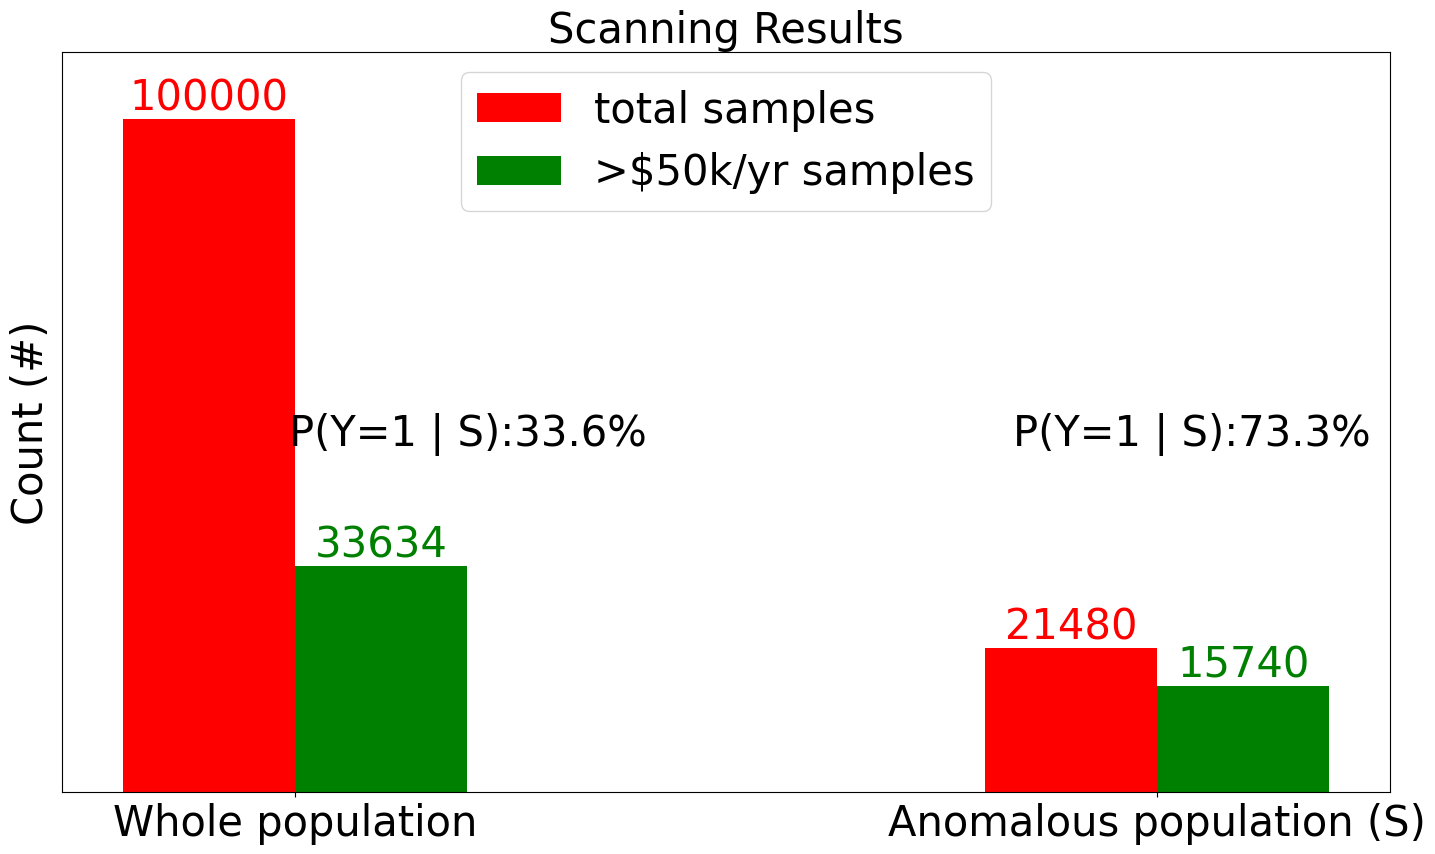

In [8]:
dff = data.copy()
dff['observed'] = observed
dff['probabilities'] = observed.mean()
describe_subset(privileged_subset,dff)

Next, We'll scan for individuals with significantly lower income level than the overall average of `0.33`. We start with a low penalty value and observe the subset we find.

In [9]:
unprivileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=True,penalty=10,num_iters=1)
print(unprivileged_subset)


({'AGEP': ['20 - 30', '30 - 50', '50 - 70', 'teen'], 'WKHP': ['0 - 10', '10 - 20', '20 - 30'], 'SCHL': ['1 or more years of college credit but no degree', '12th Grade - no diploma', 'Associate’s degree', 'Bachelor’s degree', 'GED or alternative credential', 'Grade 10', 'Grade 11', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'No schooling completed', 'Regular high school diploma', 'Some college but less than 1 year']}, 4862.2218)


Our detected privileged group has a size of 20416 which is 20.416% of the data. 
We observe 0.0487 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


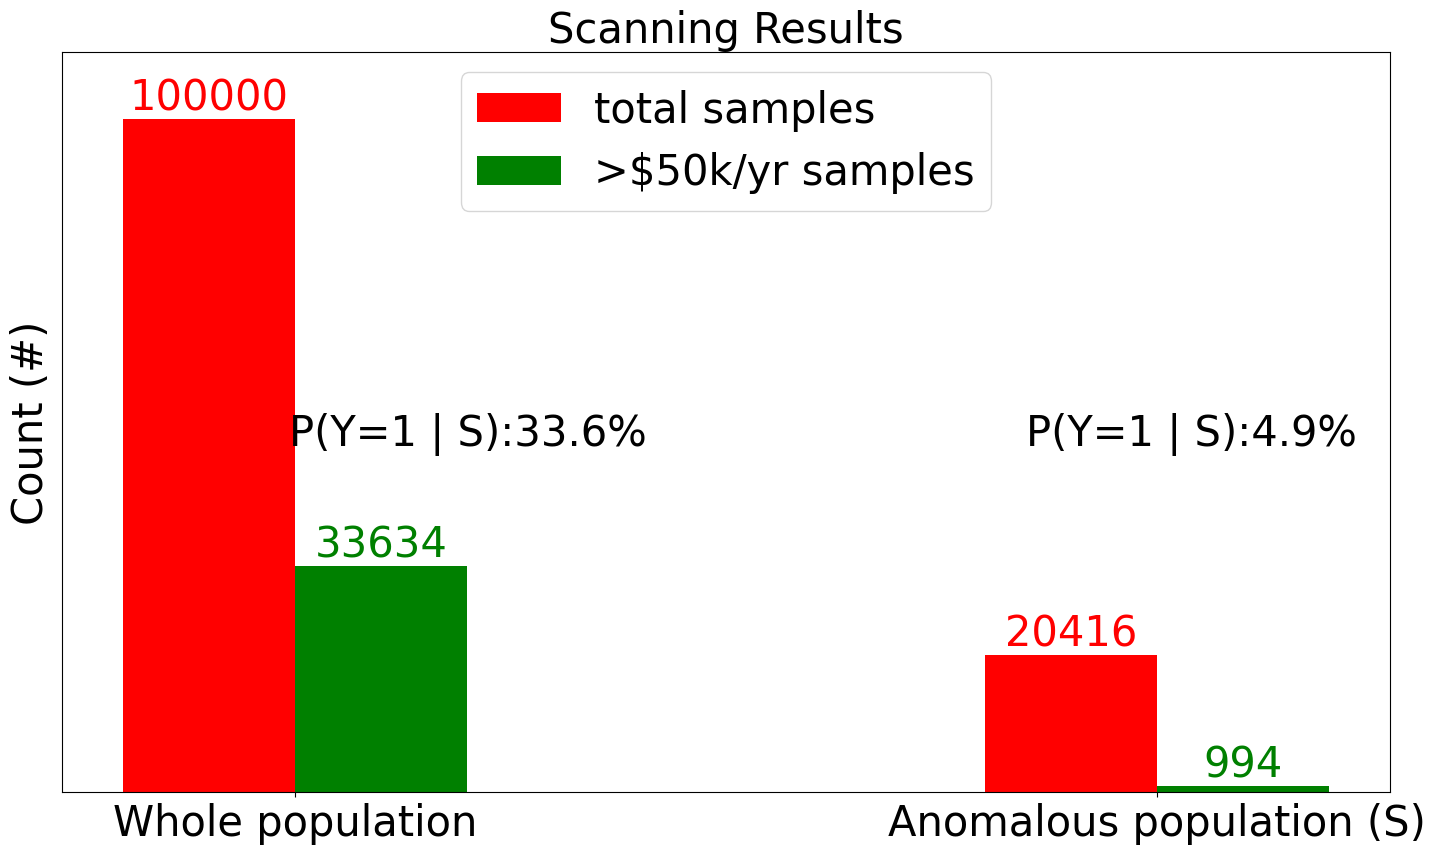

In [10]:
describe_subset(unprivileged_subset,dff)

### Penalty variation

We can also vary the penalty value which will affect the description length of the returned subset. Please note that while using a high penalty value reduces the complexity of the returned subset, there is the trade-off of obtaining a less extreme subset (lower bias score)

In [11]:
privileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=False,penalty=40, num_iters=1)
print(privileged_subset)

({'POBP': ['India']}, 119.4004)


Our detected privileged group has a size of 784 which is 0.784% of the data. 
We observe 0.6492 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


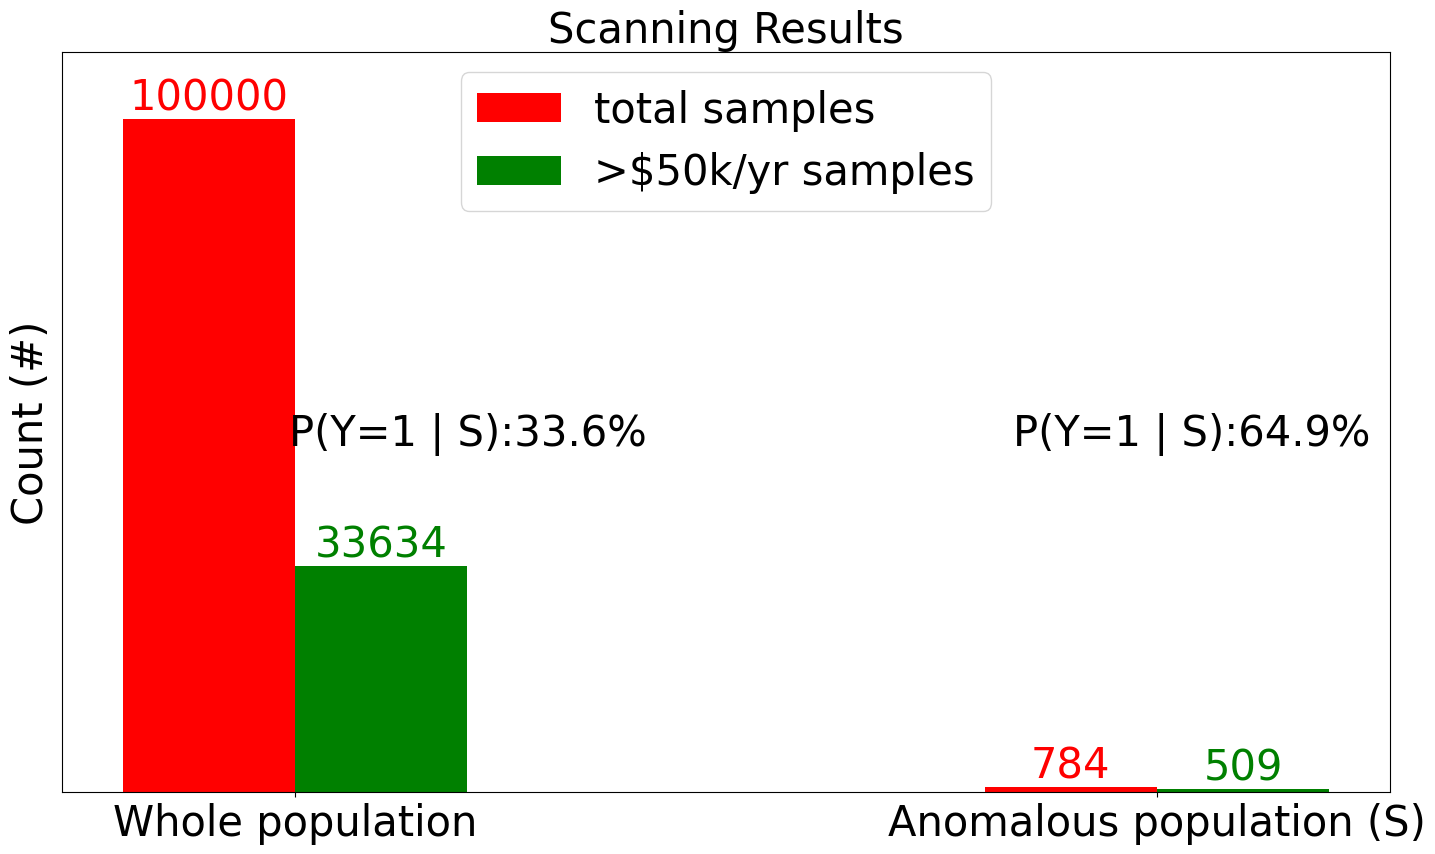

In [12]:
describe_subset(privileged_subset,dff)

## Bias scan using Multi-Dimensional Subset Scan (MDSS)

"Identifying Significant Predictive Bias in Classifiers" https://arxiv.org/abs/1611.08292

The goal of bias scan is to identify a subgroup(s) that has significantly more predictive bias than would be expected from an unbiased classifier. There are $\prod_{m=1}^{M}\left(2^{|X_{m}|}-1\right)$ unique subgroups from a dataset with $M$ features, with each feature having $|X_{m}|$ discretized values, where a subgroup is any $M$-dimension
Cartesian set product, between subsets of feature-values from each feature --- excluding the empty set. Bias scan mitigates this computational hurdle by approximately identifing the most statistically biased subgroup in linear time (rather than exponential).




In [13]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import f1_score, roc_auc_score


#### Helper functions to describe results

In [14]:

# transform feature values into numerical codes for computation   
def transform_features(X):
    for feature in X.columns:
        X[feature] = X[feature].astype('category').cat.codes
    return X

# report evaluation metrics
def report(actual, predicted):
    print('F1: ', f1_score(actual, predicted))
    print('AUC-ROC: ', roc_auc_score(actual, predicted))

# describe subset from bias scan 
def describe_subset(subset,data):
    to_choose = data[subset.keys()].isin(subset).all(axis=1)
    to_choose = to_choose.reset_index(drop=True)
    _actual = y.loc[to_choose].copy()
    _preds = preds.loc[to_choose].copy()

    print('Subgroup Results:')
    report(_actual, _preds)
    print()
    print(f"For the anomalous subgroup, the model predicts { _preds.sum()} people to earn >50K but in reality { _actual.sum()} earn this amount")
    print("Our detected subgroup has a size of {}.\nWe observe {} as the mean outcome, but our model predicts a mean outcome of {}"\
    .format(len(_preds), np.round(_actual.mean(),2), np.round(_preds.mean(),2)))
    

### Training the model

In [15]:
#transform data to numeric for the model
y = dff['observed'].reset_index(drop=True)
features = dff.drop(['observed'], axis = 1).reset_index(drop=True)
X = features.copy()
X = transform_features(X)

We train a simple classifier to predict the probability of the outcome.

In [16]:
# create model
model = GBC()

# train model
model.fit(X, y)
preds = pd.Series(model.predict(X))

# evaluate results
print('Global Results:')
report(y, preds)




Global Results:
F1:  0.664253655711597
AUC-ROC:  0.7475312169808295


### bias scan
In bias scan, we are using the predictions from the model as the expectations

In [17]:
subset, _ = bias_scan(data=features, observations=y, 
          expectations=preds, scoring='Bernoulli', 
          overpredicted=False, penalty=20, num_iters=1)

print()
print('Anomalous Subgroup:\n', subset, _)


Anomalous Subgroup:
 {'WKHP': ['0 - 10', '10 - 20', '20 - 30', '30 - 40', '80 - 90'], 'SCHL': ['1 or more years of college credit but no degree', '12th Grade - no diploma', 'Associate’s degree', 'Bachelor’s degree', 'Doctorate degree', 'GED or alternative credential', 'Grade 1', 'Grade 10', 'Grade 11', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'Professional degree beyond a bachelor’s degree', 'Regular high school diploma', 'Some college but less than 1 year']} 48192.7636


In [18]:
describe_subset(subset,dff)

Subgroup Results:
F1:  0.48775808133472365
AUC-ROC:  0.6636486717578398

For the anomalous subgroup, the model predicts 8463 people to earn >50K but in reality 15512 earn this amount
Our detected subgroup has a size of 68215.
We observe 0.23 as the mean outcome, but our model predicts a mean outcome of 0.12


In [19]:
subset, _ = bias_scan(data=features, observations=y, 
          expectations=preds, scoring='Bernoulli', 
          overpredicted=True, penalty=500)

print()
print('Anomalous Subgroup:\n', subset)


Anomalous Subgroup:
 {'SCHL': ['Bachelor’s degree', 'Doctorate degree', 'Master’s degree', 'No schooling completed', 'Professional degree beyond a bachelor’s degree'], 'WKHP': ['30 - 40', '40 - 50', '50 - 60', '60 - 70'], 'AGEP': ['30 - 50', '50 - 70']}


In [20]:
describe_subset(subset,dff)

Subgroup Results:
F1:  0.8311635475996746
AUC-ROC:  0.6321333663482056

For the anomalous subgroup, the model predicts 18672 people to earn >50K but in reality 15740 earn this amount
Our detected subgroup has a size of 22524.
We observe 0.7 as the mean outcome, but our model predicts a mean outcome of 0.83


### Concept drift
In this section, we train a model on the 2014 US Census Income data and use that model to predict on 2018 data. We then scan the predicted probabilities from the model trained on 2014 data against the actual outcomes from 2018 data. By doing this, we hope to identify a concept drift where the changes in time can be used to assess the performance degradation of the older model.

In [21]:
#transform data to numeric for the model
df_2014 = dff_2014.sample(100000,random_state=0)
y_2014 = df_2014['observed']
features_2014 = df_2014.drop(['observed'], axis = 1)
X_2014 = features_2014.copy()
X_2014 = transform_features(X_2014)

df_2018 = dff_2018.sample(100000,random_state=0)
y_2018 = df_2018['observed']
features_2018 = df_2018.drop(['observed'], axis = 1)
X_2018 = features_2018.copy()
X_2018 = transform_features(X_2018)

In [22]:
# Train model on 2014
model_2014 = GBC()
model_2014.fit(X_2014, y_2014)

# Predict on 2018 
preds_2018 = pd.Series(model_2014.predict(X_2018))

print('Global Results:')
report(y_2018, preds_2018)

Global Results:
F1:  0.640693803830251
AUC-ROC:  0.7216404836248124


In [23]:
# scan the priviledged subset
subset, _ = bias_scan(data=features_2018, observations=y_2018, 
          expectations=preds_2018, scoring='Bernoulli', 
          overpredicted=False, penalty=100)

print()
print('Anomalous Subgroup:\n', subset)


Anomalous Subgroup:
 {'SCHL': ['1 or more years of college credit but no degree', '12th Grade - no diploma', 'Associate’s degree', 'Bachelor’s degree', 'GED or alternative credential', 'Grade 10', 'Grade 11', 'Grade 5', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'Regular high school diploma', 'Some college but less than 1 year']}


In [24]:
# check model performance
describe_subset(subset,df_2018)

Subgroup Results:
F1:  0.6646639838273913
AUC-ROC:  0.7476624041867339

For the anomalous subgroup, the model predicts 24262 people to earn >50K but in reality 28667 earn this amount
Our detected subgroup has a size of 85079.
We observe 0.34 as the mean outcome, but our model predicts a mean outcome of 0.29


In [25]:
# check model performance
describe_subset(subset,df_2014)

Subgroup Results:
F1:  0.5924733161575267
AUC-ROC:  0.7125260719597886

For the anomalous subgroup, the model predicts 18693 people to earn >50K but in reality 24779 earn this amount
Our detected subgroup has a size of 86208.
We observe 0.29 as the mean outcome, but our model predicts a mean outcome of 0.22


#### Summary
This notebook demonstrates how to discover systematic deviations in data or models for a binary classification case. There are more examples that use other datasets in different domains in demo_mdss_detectors.ipynb found in the [AIF360 repo](https://github.com/Trusted-AI/AIF360) examples folder. 